## Preface



First, install `CFEDemand` package if necessary:



In [1]:
!pip install CFEDemands --upgrade

Requirement already up-to-date: CFEDemands in /srv/app/venv/lib/python3.6/site-packages


## Compensated Policy Experiments



Compare Marshallian (uncompensated) and Hicksian (compensated)
demands:



In [2]:
!pip install CFEDemands
import cfe
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

USE = "Tanzania"

if USE=="Tanzania":
    DIR = "./TanzanianNPS/"
    r = cfe.from_dataset(DIR+'tanzanian_nps.ds')
    USE_GOOD = 'Sweet Potatoes'
else:
    raise ValueError("No such value of USE")

fct = pd.read_csv('fct-full-fct-full.csv').dropna(how='all')
fct.set_index('Item name', inplace= True)
rda = pd.read_pickle(DIR+"rda.df")

# Use prices, distribution of budgets from first round, first market:
t = r.firstround  # First round
m = r.coords['m'][0] # First market

# Distribution of predicted total expenditures
xhat = r.get_predicted_expenditures().sum('i')
xhat = xhat.where(xhat>0,np.nan)

# Note selection of prices for first period and first market
p = r.prices.sel(t=t,m=m).fillna(1).copy()
newp = pd.read_csv('final-prices-our-prices-1.csv')
p.values = newp.iloc[:,0].values

def my_prices(p0,p=p,i=USE_GOOD):
    p = p.copy()
    p.loc[i] = p0
    return p

# Now fix up FCT
# Change some labels in fct
d={'protein':'Protein',
   'protein g':'Protein',
   'fat':'Fat',
   'energy_kcal':'Calories',
   'energy kcal':'Calories',
   'calcium':'Calcium',
   'ca mg':'Calcium',
   'betacarotene':'Betacarotene',
   'thiamine':'Thiamine',
   'riboflavin':'Riboflavin',
   'niacin':'Niacin',
   'iron':'Iron',
   'fe mg':'Iron',
   'ascorbic_total':'Ascorbic Acid',
   'vit a ug':'Vitamin A',
   'vit b6 mg':'Vitamin B6',
   'vit b12 ug':'Vitamin B12',
   'vit d ug':'Vitamin D',
   'vit e ug':'Vitamin E',
   'vit c mg':'Vitamin C',
   'mg mg':'Magnesium',
   'zn mg':'Zinc'}

fct = fct.rename(columns=d) #[list(d.values())]

# Fix capitalization (to match food labels)
# Replace missing with zeros
fct = fct.fillna(0)

try:
    fct.index = fct.index.droplevel('unit')
except AttributeError: pass # No units?

def nutrient_demand(x,p,z=None):
    c = r.demands(x,p,z=z)
    fct0,c0 = fct.align(c,axis=0,join='inner')
    fct0= fct0.replace(np.nan,0)
    N = fct0.T@c0

    return N

# In first round, averaged over households and villages, zbar is the average household but in our own experiements can 
# make zbar equal to households only with children
zbar = r.z.sel(t=r.firstround).mean(['j','m'])[:-1] # Leave out log HSize

# This matrix product gives minimum nutrient requirements for average
# household in first round
hh_rda = rda.replace('',0).T@zbar

def nutrient_adequacy_ratio(x,p):
    return nutrient_demand(x,p)/hh_rda

UseNutrients = ['Protein','Calories','Iron','Calcium']
x0 = 6311 #Household median budget
X = np.linspace(x0/10,x0*5,50)

# Choose reference (t,m) for reference good
ref_price = r.prices.sel(i=USE_GOOD,t=t,m=m)
P = np.linspace(ref_price/10,ref_price*5,50)

Text(0.5, 1.0, 'Marshallian and Hicksian Demands')

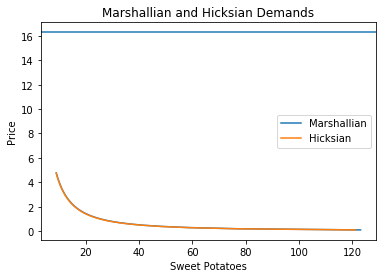

In [3]:
USE_GOOD = 'Sweet Potatoes'

U0 = r.indirect_utility(x0,p)

plt.plot([r.demands(x0,my_prices(p0,i=USE_GOOD))[USE_GOOD] for p0 in P],P)
plt.plot([r.demands(U0,my_prices(p0,i=USE_GOOD),type="Hicksian")[USE_GOOD] for p0 in P],P)
plt.ylabel('Price')
plt.xlabel(USE_GOOD)
plt.axhline(p.sel(i=USE_GOOD).values)
plt.legend(("Marshallian","Hicksian"))
plt.title("Marshallian and Hicksian Demands")

**Income effect is not as large since milk is not a hugely important component of household consumption.
At prices increase, people will consumer less rice and there will be a bigger income effect.
Horizontal difference between the two curves is the income effect

Define some useful functions for measuring costs:



In [4]:
def compensating_variation(U0,p0,p1):
    x0 = r.expenditure(U0,p0)
    x1 = r.expenditure(U0,p1)
    return x1-x0

def revenue(U0,p0,p1,type='Marshallian'):
    #(Un)Compensated revenue from taxes changing vector of prices from p0 to p1.
    #Note that this is only for *demand* side (i.e., if supply perfectly elastic).
    
    dp = p1 - p0 # Change in prices
    return dp.T@r.demands(U0,p1,type=type)


def deadweight_loss(U0,p0,p1):
    #Deadweight loss of tax/subsidy scheme creating wedge in prices from p0 to p1.
    #Note that this is only for *demand* side (i.e., if supply perfectly elastic).
  
    cv = compensating_variation(U0,p0,p1)
    return revenue(U0,p0,p1,type='Hicksian') - cv
    
def compensated_nutrient_demand(U,p,z=None):
    c = r.demands(U,p,z=z,type='Hicksian')
    fct0,c0 = fct.align(c,axis=0,join='inner')
    N = fct0.T@c0
    return N

def compensated_nutrient_adequacy_ratio(U,p):
    return compensated_nutrient_demand(U,p)/hh_rda

Text(0.5, 1.0, 'Sweet Potato Price Vs. log NAR')

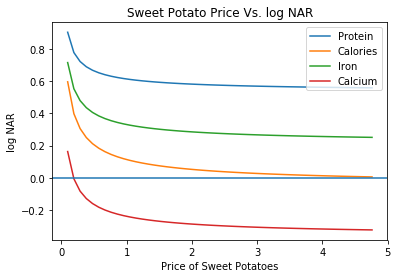

In [ ]:
fig,ax2 = plt.subplots()
ax2.set_ylabel('log NAR')
ax2.plot(P,[np.log(compensated_nutrient_adequacy_ratio(U0,my_prices(p0))[UseNutrients]) for p0 in P])
ax2.legend(UseNutrients)
ax2.axhline(0)
ax2.set_xlabel("Price of %s" % USE_GOOD)
plt.title('Sweet Potato Price Vs. log NAR')

In [ ]:
fig, ax1 = plt.subplots()

ax1.plot(P,[compensating_variation(U0,p,my_prices(p0)) for p0 in P])
ax1.set_xlabel("Price of %s" % USE_GOOD)
ax1.set_ylabel("Compensating Variation")

ax1.plot(P,[revenue(U0,p,my_prices(p0)) for p0 in P],'k')
ax1.legend(('Compensating Variation','Revenue'))
ax1.axhline(0)
ax1.axvline(p.loc[USE_GOOD])
plt.title('Compensating Variation Vs. Revenue')

Text(0.5, 1.0, 'Compensating Variation Vs. Revenue')

Increase price of rice - need to compensate more but not in a linear way (slower than rate at which price is increasing) since demand is not completely elastic
lines are very close when price 1.75-5 since demand is inelastic for those prices
can raise prices to 5 and it would be efficient 
subsidize goods that give more nutrients